# Example : k fold cross-validation with an input file 

DeepBiome package takes microbiome abundance data as input and uses the phylogenetic taxonomy to guide the decision of the optimal number of layers and neurons in the deep learning architecture.

To use DeepBiome, you can experiment (1) __k times repetition__ or (2) __k fold cross-validation__.
For each experiment, we asuume that the dataset is given by
- __A list of k input files for k times repetition.__
- __One input file for k fold cross-validation.__

This notebook contains an example of (2) __k fold cross-validation__ for the deep neural netowrk using deepbiome.

## 1. Load library

First, we load the DeepBiome package. The DeepBiome package is built on the tensorflow and keras library

In [1]:
import os
import logging
import json
from pkg_resources import resource_filename

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from deepbiome import deepbiome

Using TensorFlow backend.


## 2. Prepare the dataset

In this example, we assume that we have __one input file for k times repetition.__

DeepBiome needs 3 data files as follows:
1. **the tree information**
1. **the input file**
1. **y**

In addition, we can set **the training index for each fold**. If we set the index file, DeepBiome builds the training set for each fold based on each fold index in the index file. If not, DeepBiome will generate the index file locally.
        
Each data should have the csv format as follow:

### Example of the tree information

First we need a file about the phylogenetic tree information. This tree information file should have the format below:

In [2]:
tree_information = pd.read_csv(resource_filename('deepbiome', 'tests/data/genus48_dic.csv'))
tree_information

,Genus,Family,Order,Class,Phylum,Domain
0,Streptococcus,Streptococcaceae,Lactobacillales,Bacilli,Firmicutes,Bacteria
1,Tropheryma,Cellulomonadaceae,Actinomycetales,Actinobacteria,Actinobacteria,Bacteria
2,Veillonella,Veillonellaceae,Selenomonadales,Negativicutes,Firmicutes,Bacteria
3,Actinomyces,Actinomycetaceae,Actinomycetales,Actinobacteria,Actinobacteria,Bacteria
4,Flavobacterium,Flavobacteriaceae,Flavobacteriales,Flavobacteria,Bacteroidetes,Bacteria
5,Prevotella,Prevotellaceae,Bacteroidales,Bacteroidia,Bacteroidetes,Bacteria
6,Porphyromonas,Porphyromonadaceae,Bacteroidales,Bacteroidia,Bacteroidetes,Bacteria
7,Parvimonas,Clostridiales_Incertae_Sedis_XI,Clostridiales,Clostridia,Firmicutes,Bacteria
8,Fusobacterium,Fusobacteriaceae,Fusobacteriales,Fusobacteria,Fusobacteria,Bacteria
9,Propionibacterium,Propionibacteriaceae,Actinomycetales,Actinobacteria,Actinobacteria,Bacteria


This file has `.csv` format below:

In [3]:
with open(resource_filename('deepbiome', 'tests/data/genus48_dic.csv')) as f:
    print(f.read())

Genus,Family,Order,Class,Phylum,Domain
Streptococcus,Streptococcaceae,Lactobacillales,Bacilli,Firmicutes,Bacteria
Tropheryma,Cellulomonadaceae,Actinomycetales,Actinobacteria,Actinobacteria,Bacteria
Veillonella,Veillonellaceae,Selenomonadales,Negativicutes,Firmicutes,Bacteria
Actinomyces,Actinomycetaceae,Actinomycetales,Actinobacteria,Actinobacteria,Bacteria
Flavobacterium,Flavobacteriaceae,Flavobacteriales,Flavobacteria,Bacteroidetes,Bacteria
Prevotella,Prevotellaceae,Bacteroidales,Bacteroidia,Bacteroidetes,Bacteria
Porphyromonas,Porphyromonadaceae,Bacteroidales,Bacteroidia,Bacteroidetes,Bacteria
Parvimonas,Clostridiales_Incertae_Sedis_XI,Clostridiales,Clostridia,Firmicutes,Bacteria
Fusobacterium,Fusobacteriaceae,Fusobacteriales,Fusobacteria,Fusobacteria,Bacteria
Propionibacterium,Propionibacteriaceae,Actinomycetales,Actinobacteria,Actinobacteria,Bacteria
Gemella,Bacillales_Incertae_Sedis_XI,Bacillales,Bacilli,Firmicutes,Bacteria
Rothia,Micrococcaceae,Actinomycetales,Actinobacteria,Act

### Example of the input file

Below is an example of the input file.
This example has 1000 samples' microbiome abandunce.

In [4]:
x = pd.read_csv(resource_filename('deepbiome', 'tests/data/onefile_x.csv'))
x.head()

,Streptococcus,Tropheryma,Veillonella,Actinomyces,Flavobacterium,Prevotella,Porphyromonas,Parvimonas,Fusobacterium,Propionibacterium,...,Microbacterium,Sphingomonas,Chryseobacterium,Bacteroides,Bdellovibrio,Streptophyta,Lachnospiracea_incertae_sedis,Paracoccus,Fastidiosipila,Pseudonocardia
0,841,0,813,505,5,3224,0,362,11,65,...,0,87,0,0,0,0,0,0,0,2133
1,1445,0,1,573,0,1278,82,85,69,154,...,0,1,2,0,0,0,0,0,0,3638
2,1259,0,805,650,0,1088,0,0,74,0,...,0,2,8,1,39,0,0,0,0,3445
3,982,0,327,594,0,960,81,19,9,0,...,157,1,0,4,60,0,0,0,0,3507
4,1162,0,130,969,163,1515,167,4,162,3,...,0,9,0,0,0,0,60,0,0,3945


In [5]:
x.tail()

,Streptococcus,Tropheryma,Veillonella,Actinomyces,Flavobacterium,Prevotella,Porphyromonas,Parvimonas,Fusobacterium,Propionibacterium,...,Microbacterium,Sphingomonas,Chryseobacterium,Bacteroides,Bdellovibrio,Streptophyta,Lachnospiracea_incertae_sedis,Paracoccus,Fastidiosipila,Pseudonocardia
995,1401,4,30,526,0,923,25,0,127,0,...,0,0,7,0,0,0,0,0,0,4470
996,2655,6,106,74,0,952,76,13,158,125,...,0,2,0,0,0,0,0,0,0,2826
997,335,0,71,259,67,718,1,4,4,167,...,0,246,0,0,6,0,0,0,0,6527
998,649,69,966,1227,0,508,2,30,550,0,...,0,0,0,0,0,6,0,0,0,4402
999,1258,0,0,1119,0,2348,25,0,137,176,...,0,2,0,0,0,0,0,0,0,2585


This file has `.csv` format below:

In [6]:
with open(resource_filename('deepbiome', 'tests/data/onefile_x.csv')) as f:
    print(f.read())

"Streptococcus","Tropheryma","Veillonella","Actinomyces","Flavobacterium","Prevotella","Porphyromonas","Parvimonas","Fusobacterium","Propionibacterium","Gemella","Rothia","Granulicatella","Neisseria","Lactobacillus","Megasphaera","Catonella","Atopobium","Campylobacter","Capnocytophaga","Solobacterium","Moryella","TM7_genera_incertae_sedis","Staphylococcus","Filifactor","Oribacterium","Burkholderia","Sneathia","Treponema","Moraxella","Haemophilus","Selenomonas","Corynebacterium","Rhizobium","Bradyrhizobium","Methylobacterium","OD1_genera_incertae_sedis","Finegoldia","Microbacterium","Sphingomonas","Chryseobacterium","Bacteroides","Bdellovibrio","Streptophyta","Lachnospiracea_incertae_sedis","Paracoccus","Fastidiosipila","Pseudonocardia"
841,0,813,505,5,3224,0,362,11,65,156,1,55,0,1,20,382,1,333,24,80,43,309,2,3,4,0,1,32,0,2,4,382,0,0,96,23,0,0,87,0,0,0,0,0,0,0,2133
1445,0,1,573,0,1278,82,85,69,154,436,3,0,61,440,0,394,83,33,123,0,49,414,0,0,37,0,0,42,0,0,384,27,0,0,0,146,0,0,1,2,0,0,0,0

### Example of the Y (regression)

This is an example of the output file for regression problem.

In [7]:
y = pd.read_csv(resource_filename('deepbiome', 'tests/data/onefile_regression_y.csv'))
y.head()

,x1
0,4.997270
1,5.004092
2,5.485126
3,5.489590
4,1.500001


In [8]:
y.tail()

,x1
995,2.609926
996,5.488959
997,3.498418
998,5.486107
999,5.319623


### Example of the Y (classification)

This is an example of the output file for classification problem. Below example file has 1000 samples in rows.

In [9]:
y = pd.read_csv(resource_filename('deepbiome', 'tests/data/onefile_classification_y.csv'))
y.head()

,V1
0,1.0
1,1.0
2,0.0
3,0.0
4,1.0


In [10]:
y.tail()

,V1
995,1.0
996,0.0
997,1.0
998,0.0
999,1.0


### Exmple of the training index file for `k` fold cross-validation

For each fold, we have to set the training and test set. If the index file is given, DeepBiome sets the training set and test set based on the index file for 5 fold cross-validation. Below is the example of the index file. Each column has the training indices for each fold. DeepBiome will only use the samples in this index set for training.

In [11]:
idxs = pd.read_csv(resource_filename('deepbiome', 'tests/data/onefile_idx.csv'), dtype=np.int)
idxs.head()

,0,1,2,3,4
0,1,1,3,1,1
1,2,2,4,2,2
2,3,3,5,3,4
3,6,4,7,4,5
4,7,5,9,5,6


In [12]:
idxs.tail()

,0,1,2,3,4
795,994,996,994,995,996
796,995,997,995,996,997
797,997,998,996,997,998
798,999,999,998,998,999
799,1000,1000,999,1000,1000


Below is the index set for 1st fold. From 1000 samples above, it uses 800 samples for training.

In [13]:
idxs.iloc[:,0].head()

0    1
1    2
2    3
3    6
4    7
Name: 0, dtype: int64

In [14]:
idxs.iloc[:,0].tail()

795     994
796     995
797     997
798     999
799    1000
Name: 0, dtype: int64

## 3. Prepare the configuration

For detailed configuration, we can build the configuration information for the network training by:
1. the python dictionary format
1. the configufation file (.cfg).

In this notebook, we show the python dictionary format configuration.

Please check the detailed information about each option in the [documantation](https://young-won.github.io/deepbiome/prerequisites.html#configuration)

### For preparing the configuration about the network information (`network_info`)

To give the information about the training process, we provide a dictionary of configurations to the `netowrk_info` field.
Your configuration for the network training should include the information about:

In [15]:
network_info = {
    'architecture_info': {
        'batch_normalization': 'False',
        'drop_out': '0',
        'weight_initial': 'glorot_uniform',
        'weight_l1_penalty':'0.',
        'weight_decay': 'phylogenetic_tree',
    },
    'model_info': {
        'lr': '0.01',
        'decay': '0.001',
        'loss': 'binary_crossentropy',
        'metrics': 'binary_accuracy, sensitivity, specificity, gmeasure',
        'taxa_selection_metrics': 'sensitivity, specificity, gmeasure, accuracy',
        'network_class': 'DeepBiomeNetwork',
        'optimizer': 'adam',
        'reader_class': 'MicroBiomeClassificationReader',
        'normalizer': 'normalize_minmax',
    },
    'training_info': {
        'epochs': '10',
        'batch_size': '50', 
        'callbacks': 'ModelCheckpoint',
        'monitor': 'val_loss',
        'mode' : 'min',
        'min_delta': '1e-7',
    },
    'validation_info': {
        'batch_size': 'None', 
        'validation_size': '0.2'
    },
    'test_info': {
        'batch_size': 'None'
    }
}

### For preparing the configuration about the path information (`path_info`)

To give the information about the path of dataset, paths for saving the trained weights and the evaluation results, we provide a dictionary of configurations to the `path_info` field.
Your configuration for the network training should include the information about:

In [16]:
path_info = {
    'data_info': {
        'data_path': resource_filename('deepbiome', 'tests/data'),
        'idx_path': resource_filename('deepbiome', 'tests/data/onefile_idx.csv'),
        'tree_info_path': resource_filename('deepbiome', 'tests/data/genus48_dic.csv'),
        'x_path': 'onefile_x.csv',
        'y_path': 'classification_y.csv'
    },
    'model_info': {
        'evaluation': 'eval.npy',
        'history': 'hist.json',
        'model_dir': './example_result/',
        'weight': 'weight.h5'
    }
}

## 4. Deepbiome Training

Now we can train the DeepBiome network based on the configurations.

For logging, we used the python logging library.

In [17]:
logging.basicConfig(format = '[%(name)-8s|%(levelname)s|%(filename)s:%(lineno)s] %(message)s',
                    level=logging.DEBUG)
log = logging.getLogger()

The deeobiome_train function provide the test evaluation, train evaluation and the deepbiome network instance.

If we set `number_of_fold`, then DeepBiome performs cross-validation based on that value. If not, DeepBiome package performs cross-validation based on the index file. If both `number_of_fold` option and the index file are missing, then the library performs leave-one-out-cross-validation (LOOCV).

In [18]:
test_evaluation, train_evaluation, network = deepbiome.deepbiome_train(log, network_info, path_info, number_of_fold=None)

[root    |INFO|deepbiome.py:105] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:142] -------1 simulation start!----------------------------------
[root    |INFO|readers.py:57] -----------------------------------------------------------------------
[root    |INFO|readers.py:58] Construct Dataset
[root    |INFO|readers.py:59] -----------------------------------------------------------------------
[root    |INFO|readers.py:60] Load data
[root    |INFO|deepbiome.py:152] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:153] Build network for 1 simulation
[root    |INFO|build_network.py:506] ------------------------------------------------------------------------------------------
[root    |INFO|build_network.py:507] Read phylogenetic tree information from /DATA/home/muha/github_repos/deepbiome/deepbiome/tests/data/genus48_dic.csv
[root    |INFO|build_network.py:512] Phylogenetic tree level list: ['Ge

Instructions for updating:
Colocations handled automatically by placer.


[tensorflow|WARNING|deprecation.py:328] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/resource_variable_ops.py:432: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
[root    |INFO|build_network.py:636] ------------------------------------------------------------------------------------------


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 48)                0         
_________________________________________________________________
l1_dense (Dense_with_tree)   (None, 40)                1960      
_________________________________________________________________
l1_activation (Activation)   (None, 40)                0         
_________________________________________________________________
l2_dense (Dense_with_tree)   (None, 23)                943       
_________________________________________________________________
l2_activation (Activation)   (None, 23)                0         
_________________________________________________________________
l3_dense (Dense_with_tree)   (None, 17)                408       
_________________________________________________________________
l3_activation (Activation)   (None, 17)                0   

[root    |INFO|build_network.py:57] Build Network
[root    |INFO|build_network.py:58] Optimizer = adam
[root    |INFO|build_network.py:59] Loss = binary_crossentropy
[root    |INFO|build_network.py:60] Metrics = binary_accuracy, sensitivity, specificity, gmeasure
[root    |INFO|deepbiome.py:162] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:163] 1 fold computing start!----------------------------------
[root    |INFO|build_network.py:133] Training start!


Instructions for updating:
Use tf.cast instead.


[tensorflow|WARNING|deprecation.py:328] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_ops.py:2862: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Train on 640 samples, validate on 160 samples
Epoch 1/10
640/640 [==============================] - 1s 1ms/step - loss: 0.6688 - binary_accuracy: 0.6844 - sensitivity: 0.9904 - specificity: 0.0171 - gmeasure: 0.0339 - val_loss: 0.6381 - val_binary_accuracy: 0.6938 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 2/10
640/640 [==============================] - 0s 148us/step - loss: 0.6274 - binary_accuracy: 0.6844 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - val_loss: 0.6161 - val_binary_accuracy: 0.6938 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 3/10
640/640 [==============================] - 0s 132us/step - loss: 0.6260 - binary_accuracy: 0.6844 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - val_loss: 0.6163 - val_binary_accuracy: 0.6938 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 4/10
640/640 [========

[root    |INFO|build_network.py:83] Load trained model weight at ./example_result/weight_0.h5 
[root    |INFO|build_network.py:143] Training end with time 3.6673941612243652!
[root    |INFO|build_network.py:79] Saved trained model weight at ./example_result/weight_0.h5 
[root    |DEBUG|deepbiome.py:171] Save weight at ./example_result/weight_0.h5
[root    |DEBUG|deepbiome.py:174] Save history at ./example_result/hist_0.json
[root    |INFO|build_network.py:169] Evaluation start!


800/800 [==============================] - 0s 4us/step


[root    |INFO|build_network.py:174] Evaluation end with time 0.008848905563354492!
[root    |INFO|build_network.py:175] Evaluation: [0.6217131614685059, 0.6862499713897705, 1.0, 0.0, 0.0]
[root    |INFO|build_network.py:169] Evaluation start!


200/200 [==============================] - 0s 11us/step


[root    |INFO|build_network.py:174] Evaluation end with time 0.008173465728759766!
[root    |INFO|build_network.py:175] Evaluation: [0.6188117265701294, 0.6899999976158142, 1.0, 0.0, 0.0]
[root    |INFO|deepbiome.py:185] Compute time : 5.801676273345947
[root    |INFO|deepbiome.py:186] 1 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:142] -------2 simulation start!----------------------------------
[root    |INFO|readers.py:57] -----------------------------------------------------------------------
[root    |INFO|readers.py:58] Construct Dataset
[root    |INFO|readers.py:59] -----------------------------------------------------------------------
[root    |INFO|readers.py:60] Load data
[root    |INFO|deepbiome.py:152] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:153] Build network for 2 simulation
[root    |INFO|build_network.py:506] -----------------------------------------------------------

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 48)                0         
_________________________________________________________________
l1_dense (Dense_with_tree)   (None, 40)                1960      
_________________________________________________________________
l1_activation (Activation)   (None, 40)                0         
_________________________________________________________________
l2_dense (Dense_with_tree)   (None, 23)                943       
_________________________________________________________________
l2_activation (Activation)   (None, 23)                0         
_________________________________________________________________
l3_dense (Dense_with_tree)   (None, 17)                408       
_________________________________________________________________
l3_activation (Activation)   (None, 17)                0   

[root    |INFO|build_network.py:57] Build Network
[root    |INFO|build_network.py:58] Optimizer = adam
[root    |INFO|build_network.py:59] Loss = binary_crossentropy
[root    |INFO|build_network.py:60] Metrics = binary_accuracy, sensitivity, specificity, gmeasure
[root    |INFO|deepbiome.py:162] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:163] 2 fold computing start!----------------------------------
[root    |INFO|build_network.py:133] Training start!


Train on 640 samples, validate on 160 samples
Epoch 1/10
640/640 [==============================] - 1s 900us/step - loss: 0.6633 - binary_accuracy: 0.6844 - sensitivity: 0.9253 - specificity: 0.0718 - gmeasure: 0.0126 - val_loss: 0.6248 - val_binary_accuracy: 0.7375 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 2/10
640/640 [==============================] - 0s 150us/step - loss: 0.6132 - binary_accuracy: 0.7156 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - val_loss: 0.5790 - val_binary_accuracy: 0.7375 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 3/10
640/640 [==============================] - 0s 146us/step - loss: 0.5978 - binary_accuracy: 0.7156 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - val_loss: 0.5757 - val_binary_accuracy: 0.7375 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 4/10
640/640 [======

[root    |INFO|build_network.py:83] Load trained model weight at ./example_result/weight_1.h5 
[root    |INFO|build_network.py:143] Training end with time 3.050985336303711!
[root    |INFO|build_network.py:79] Saved trained model weight at ./example_result/weight_1.h5 
[root    |DEBUG|deepbiome.py:171] Save weight at ./example_result/weight_1.h5
[root    |DEBUG|deepbiome.py:174] Save history at ./example_result/hist_1.json
[root    |INFO|build_network.py:169] Evaluation start!


800/800 [==============================] - 0s 3us/step


[root    |INFO|build_network.py:174] Evaluation end with time 0.008363962173461914!
[root    |INFO|build_network.py:175] Evaluation: [0.59357750415802, 0.7200000286102295, 1.0, 0.0, 0.0]
[root    |INFO|build_network.py:169] Evaluation start!


200/200 [==============================] - 0s 10us/step


[root    |INFO|build_network.py:174] Evaluation end with time 0.00813150405883789!
[root    |INFO|build_network.py:175] Evaluation: [0.5935779809951782, 0.7200000286102295, 1.0, 0.0, 0.0]
[root    |INFO|deepbiome.py:185] Compute time : 4.187489986419678
[root    |INFO|deepbiome.py:186] 2 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:142] -------3 simulation start!----------------------------------
[root    |INFO|readers.py:57] -----------------------------------------------------------------------
[root    |INFO|readers.py:58] Construct Dataset
[root    |INFO|readers.py:59] -----------------------------------------------------------------------
[root    |INFO|readers.py:60] Load data
[root    |INFO|deepbiome.py:152] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:153] Build network for 3 simulation
[root    |INFO|build_network.py:506] ------------------------------------------------------------

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 48)                0         
_________________________________________________________________
l1_dense (Dense_with_tree)   (None, 40)                1960      
_________________________________________________________________
l1_activation (Activation)   (None, 40)                0         
_________________________________________________________________
l2_dense (Dense_with_tree)   (None, 23)                943       
_________________________________________________________________
l2_activation (Activation)   (None, 23)                0         
_________________________________________________________________
l3_dense (Dense_with_tree)   (None, 17)                408       
_________________________________________________________________
l3_activation (Activation)   (None, 17)                0   

[root    |INFO|build_network.py:57] Build Network
[root    |INFO|build_network.py:58] Optimizer = adam
[root    |INFO|build_network.py:59] Loss = binary_crossentropy
[root    |INFO|build_network.py:60] Metrics = binary_accuracy, sensitivity, specificity, gmeasure
[root    |INFO|deepbiome.py:162] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:163] 3 fold computing start!----------------------------------
[root    |INFO|build_network.py:133] Training start!


Train on 640 samples, validate on 160 samples
Epoch 1/10
640/640 [==============================] - 1s 857us/step - loss: 0.6623 - binary_accuracy: 0.6812 - sensitivity: 0.9780 - specificity: 0.0192 - gmeasure: 0.0325 - val_loss: 0.6238 - val_binary_accuracy: 0.7000 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 2/10
640/640 [==============================] - 0s 133us/step - loss: 0.6187 - binary_accuracy: 0.6969 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - val_loss: 0.6120 - val_binary_accuracy: 0.7000 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 3/10
640/640 [==============================] - 0s 141us/step - loss: 0.6178 - binary_accuracy: 0.6969 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - val_loss: 0.6115 - val_binary_accuracy: 0.7000 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 4/10
640/640 [======

[root    |INFO|build_network.py:83] Load trained model weight at ./example_result/weight_2.h5 
[root    |INFO|build_network.py:143] Training end with time 3.277617931365967!
[root    |INFO|build_network.py:79] Saved trained model weight at ./example_result/weight_2.h5 
[root    |DEBUG|deepbiome.py:171] Save weight at ./example_result/weight_2.h5
[root    |DEBUG|deepbiome.py:174] Save history at ./example_result/hist_2.json
[root    |INFO|build_network.py:169] Evaluation start!


800/800 [==============================] - 0s 3us/step


[root    |INFO|build_network.py:174] Evaluation end with time 0.009271860122680664!
[root    |INFO|build_network.py:175] Evaluation: [0.6129481196403503, 0.6974999904632568, 1.0, 0.0, 0.0]
[root    |INFO|build_network.py:169] Evaluation start!


200/200 [==============================] - 0s 10us/step


[root    |INFO|build_network.py:174] Evaluation end with time 0.008469581604003906!
[root    |INFO|build_network.py:175] Evaluation: [0.6488675475120544, 0.6549999713897705, 1.0, 0.0, 0.0]
[root    |INFO|deepbiome.py:185] Compute time : 4.427377462387085
[root    |INFO|deepbiome.py:186] 3 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:142] -------4 simulation start!----------------------------------
[root    |INFO|readers.py:57] -----------------------------------------------------------------------
[root    |INFO|readers.py:58] Construct Dataset
[root    |INFO|readers.py:59] -----------------------------------------------------------------------
[root    |INFO|readers.py:60] Load data
[root    |INFO|deepbiome.py:152] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:153] Build network for 4 simulation
[root    |INFO|build_network.py:506] -----------------------------------------------------------

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 48)                0         
_________________________________________________________________
l1_dense (Dense_with_tree)   (None, 40)                1960      
_________________________________________________________________
l1_activation (Activation)   (None, 40)                0         
_________________________________________________________________
l2_dense (Dense_with_tree)   (None, 23)                943       
_________________________________________________________________
l2_activation (Activation)   (None, 23)                0         
_________________________________________________________________
l3_dense (Dense_with_tree)   (None, 17)                408       
_________________________________________________________________
l3_activation (Activation)   (None, 17)                0   

[root    |INFO|build_network.py:59] Loss = binary_crossentropy
[root    |INFO|build_network.py:60] Metrics = binary_accuracy, sensitivity, specificity, gmeasure
[root    |INFO|deepbiome.py:162] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:163] 4 fold computing start!----------------------------------
[root    |INFO|build_network.py:133] Training start!


Train on 640 samples, validate on 160 samples
Epoch 1/10
640/640 [==============================] - 1s 885us/step - loss: 0.6562 - binary_accuracy: 0.6703 - sensitivity: 0.9604 - specificity: 0.0317 - gmeasure: 0.0344 - val_loss: 0.6265 - val_binary_accuracy: 0.6875 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 2/10
640/640 [==============================] - 0s 154us/step - loss: 0.6315 - binary_accuracy: 0.6859 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - val_loss: 0.6254 - val_binary_accuracy: 0.6875 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 3/10
640/640 [==============================] - 0s 147us/step - loss: 0.6247 - binary_accuracy: 0.6859 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - val_loss: 0.6212 - val_binary_accuracy: 0.6875 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 4/10
640/640 [======

[root    |INFO|build_network.py:83] Load trained model weight at ./example_result/weight_3.h5 
[root    |INFO|build_network.py:143] Training end with time 3.1294167041778564!
[root    |INFO|build_network.py:79] Saved trained model weight at ./example_result/weight_3.h5 
[root    |DEBUG|deepbiome.py:171] Save weight at ./example_result/weight_3.h5
[root    |DEBUG|deepbiome.py:174] Save history at ./example_result/hist_3.json
[root    |INFO|build_network.py:169] Evaluation start!


800/800 [==============================] - 0s 3us/step


[root    |INFO|build_network.py:174] Evaluation end with time 0.009664773941040039!
[root    |INFO|build_network.py:175] Evaluation: [0.6220468878746033, 0.6862499713897705, 1.0, 0.0, 0.0]
[root    |INFO|build_network.py:169] Evaluation start!


200/200 [==============================] - 0s 11us/step


[root    |INFO|build_network.py:174] Evaluation end with time 0.008651971817016602!
[root    |INFO|build_network.py:175] Evaluation: [0.6190881133079529, 0.6899999976158142, 1.0, 0.0, 0.0]
[root    |INFO|deepbiome.py:185] Compute time : 4.24856162071228
[root    |INFO|deepbiome.py:186] 4 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:142] -------5 simulation start!----------------------------------
[root    |INFO|readers.py:57] -----------------------------------------------------------------------
[root    |INFO|readers.py:58] Construct Dataset
[root    |INFO|readers.py:59] -----------------------------------------------------------------------
[root    |INFO|readers.py:60] Load data
[root    |INFO|deepbiome.py:152] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:153] Build network for 5 simulation
[root    |INFO|build_network.py:506] ------------------------------------------------------------

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 48)                0         
_________________________________________________________________
l1_dense (Dense_with_tree)   (None, 40)                1960      
_________________________________________________________________
l1_activation (Activation)   (None, 40)                0         
_________________________________________________________________
l2_dense (Dense_with_tree)   (None, 23)                943       
_________________________________________________________________
l2_activation (Activation)   (None, 23)                0         
_________________________________________________________________
l3_dense (Dense_with_tree)   (None, 17)                408       
_________________________________________________________________
l3_activation (Activation)   (None, 17)                0   

[root    |INFO|build_network.py:57] Build Network
[root    |INFO|build_network.py:58] Optimizer = adam
[root    |INFO|build_network.py:59] Loss = binary_crossentropy
[root    |INFO|build_network.py:60] Metrics = binary_accuracy, sensitivity, specificity, gmeasure
[root    |INFO|deepbiome.py:162] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:163] 5 fold computing start!----------------------------------
[root    |INFO|build_network.py:133] Training start!


Train on 640 samples, validate on 160 samples
Epoch 1/10
640/640 [==============================] - 1s 866us/step - loss: 0.6639 - binary_accuracy: 0.6766 - sensitivity: 0.9958 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - val_loss: 0.6257 - val_binary_accuracy: 0.6938 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 2/10
640/640 [==============================] - 0s 148us/step - loss: 0.6314 - binary_accuracy: 0.6797 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - val_loss: 0.6169 - val_binary_accuracy: 0.6938 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 3/10
640/640 [==============================] - 0s 141us/step - loss: 0.6278 - binary_accuracy: 0.6797 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - val_loss: 0.6175 - val_binary_accuracy: 0.6938 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 4/10
640/640

[root    |INFO|build_network.py:83] Load trained model weight at ./example_result/weight_4.h5 
[root    |INFO|build_network.py:143] Training end with time 3.0704593658447266!
[root    |INFO|build_network.py:79] Saved trained model weight at ./example_result/weight_4.h5 
[root    |DEBUG|deepbiome.py:171] Save weight at ./example_result/weight_4.h5
[root    |DEBUG|deepbiome.py:174] Save history at ./example_result/hist_4.json
[root    |INFO|build_network.py:169] Evaluation start!


800/800 [==============================] - 0s 4us/step


[root    |INFO|build_network.py:174] Evaluation end with time 0.010402679443359375!
[root    |INFO|build_network.py:175] Evaluation: [0.6244432926177979, 0.6825000047683716, 1.0, 0.0, 0.0]
[root    |INFO|build_network.py:169] Evaluation start!


200/200 [==============================] - 0s 11us/step


[root    |INFO|build_network.py:174] Evaluation end with time 0.008820056915283203!
[root    |INFO|build_network.py:175] Evaluation: [0.6069634556770325, 0.7049999833106995, 1.0, 0.0, 0.0]
[root    |INFO|deepbiome.py:185] Compute time : 4.219247579574585
[root    |INFO|deepbiome.py:186] 5 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:189] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:191] Train Evaluation : ['loss' 'binary_accuracy' 'sensitivity' 'specificity' 'gmeasure']
[root    |INFO|deepbiome.py:194]       mean : [0.61494579 0.69449999 1.         0.         0.        ]
[root    |INFO|deepbiome.py:195]        std : [0.01137559 0.01370677 0.         0.         0.        ]
[root    |INFO|deepbiome.py:196] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:198] Test Evaluation : ['loss' 'binary_accuracy' 'sensitivity' 'specificity' 'gmeasure']
[root 

The `deepbiome_train` saves the trained model weights, evaluation results and history based on the path information from the configuration.

From the example above, we can check that `hist_*.json`, `weight_*.h5`, `test_eval.npy`, `train_eval.npy` files were saved.

In [19]:
os.listdir(path_info['model_info']['model_dir'])

['hist_0.json',
 'weight_2.h5',
 'test_eval.npy',
 'weight_0.h5',
 'train_eval.npy',
 'hist_2.json',
 'hist_4.json',
 'weight_3.h5',
 'hist_3.json',
 'weight_1.h5',
 'weight_4.h5',
 'hist_1.json']

Lets check the history files.

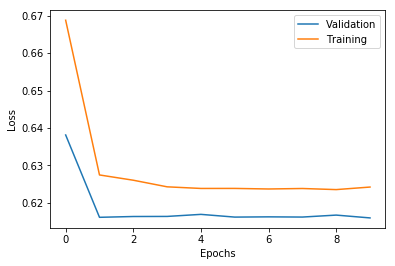

In [20]:
with open('./%s/hist_0.json' % path_info['model_info']['model_dir'], 'r') as f:
    history = json.load(f)
    
plt.plot(history['val_loss'], label='Validation')
plt.plot(history['loss'], label='Training')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Test evauation and train evauation is the numpy array of the shape (number of folds, number of evaluation measures).

In [21]:
test_evaluation

array([[0.61881173, 0.69      , 1.        , 0.        , 0.        ],
       [0.59357798, 0.72000003, 1.        , 0.        , 0.        ],
       [0.64886755, 0.65499997, 1.        , 0.        , 0.        ],
       [0.61908811, 0.69      , 1.        , 0.        , 0.        ],
       [0.60696346, 0.70499998, 1.        , 0.        , 0.        ]])

In [22]:
train_evaluation

array([[0.62171316, 0.68624997, 1.        , 0.        , 0.        ],
       [0.5935775 , 0.72000003, 1.        , 0.        , 0.        ],
       [0.61294812, 0.69749999, 1.        , 0.        , 0.        ],
       [0.62204689, 0.68624997, 1.        , 0.        , 0.        ],
       [0.62444329, 0.6825    , 1.        , 0.        , 0.        ]])

## 5. Load the pre-trained network for training

If you have a pre-trianed model, you warm_start next training using the pre-trained weights by setting the `warm_start` option in `training_info` to `True`. The file path of the pre-trained weights passed in the `warm_start_model` option. Below is the example:

In [23]:
warm_start_network_info = {
    'architecture_info': {
        'batch_normalization': 'False',
        'drop_out': '0',
        'weight_initial': 'glorot_uniform',
        'weight_l1_penalty':'0.',
        'weight_decay': 'phylogenetic_tree',
    },
    'model_info': {
        'decay': '0.001',
        'loss': 'binary_crossentropy',
        'lr': '0.01',
        'metrics': 'binary_accuracy, sensitivity, specificity, gmeasure',
        'network_class': 'DeepBiomeNetwork',
        'normalizer': 'normalize_minmax',
        'optimizer': 'adam',
        'reader_class': 'MicroBiomeClassificationReader',
        'taxa_selection_metrics': 'sensitivity, specificity, gmeasure, accuracy',
    },
    'training_info': {
        'warm_start':'True',
        'warm_start_model':'./example_result/weight.h5',
        'epochs': '10',
        'batch_size': '50',
        'callbacks': 'ModelCheckpoint',
        'monitor': 'val_loss',
        'mode' : 'min',
        'min_delta': '1e-7',
    },
    'validation_info': {
        'batch_size': 'None', 
        'validation_size': '0.2'
    },
    'test_info': {
        'batch_size': 'None'
    }
}

In [24]:
test_evaluation, train_evaluation, network = deepbiome.deepbiome_train(log, warm_start_network_info, path_info, 
                                                                       number_of_fold=None)

[root    |INFO|deepbiome.py:105] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:142] -------1 simulation start!----------------------------------
[root    |INFO|readers.py:57] -----------------------------------------------------------------------
[root    |INFO|readers.py:58] Construct Dataset
[root    |INFO|readers.py:59] -----------------------------------------------------------------------
[root    |INFO|readers.py:60] Load data
[root    |INFO|deepbiome.py:152] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:153] Build network for 1 simulation
[root    |INFO|build_network.py:506] ------------------------------------------------------------------------------------------
[root    |INFO|build_network.py:507] Read phylogenetic tree information from /DATA/home/muha/github_repos/deepbiome/deepbiome/tests/data/genus48_dic.csv
[root    |INFO|build_network.py:512] Phylogenetic tree level list: ['Ge

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 48)                0         
_________________________________________________________________
l1_dense (Dense_with_tree)   (None, 40)                1960      
_________________________________________________________________
l1_activation (Activation)   (None, 40)                0         
_________________________________________________________________
l2_dense (Dense_with_tree)   (None, 23)                943       
_________________________________________________________________
l2_activation (Activation)   (None, 23)                0         
_________________________________________________________________
l3_dense (Dense_with_tree)   (None, 17)                408       
_________________________________________________________________
l3_activation (Activation)   (None, 17)                0   

[root    |INFO|build_network.py:57] Build Network
[root    |INFO|build_network.py:58] Optimizer = adam
[root    |INFO|build_network.py:59] Loss = binary_crossentropy
[root    |INFO|build_network.py:60] Metrics = binary_accuracy, sensitivity, specificity, gmeasure
[root    |INFO|build_network.py:83] Load trained model weight at ./example_result/weight_0.h5 
[root    |INFO|deepbiome.py:162] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:163] 1 fold computing start!----------------------------------
[root    |INFO|build_network.py:133] Training start!


Train on 640 samples, validate on 160 samples
Epoch 1/10
640/640 [==============================] - 1s 844us/step - loss: 0.6247 - binary_accuracy: 0.6844 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - val_loss: 0.6167 - val_binary_accuracy: 0.6938 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 2/10
640/640 [==============================] - 0s 142us/step - loss: 0.6237 - binary_accuracy: 0.6844 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - val_loss: 0.6158 - val_binary_accuracy: 0.6938 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 3/10
640/640 [==============================] - 0s 147us/step - loss: 0.6230 - binary_accuracy: 0.6844 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - val_loss: 0.6157 - val_binary_accuracy: 0.6938 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 4/10
640/640

[root    |INFO|build_network.py:83] Load trained model weight at ./example_result/weight_0.h5 
[root    |INFO|build_network.py:143] Training end with time 3.2461724281311035!
[root    |INFO|build_network.py:79] Saved trained model weight at ./example_result/weight_0.h5 
[root    |DEBUG|deepbiome.py:171] Save weight at ./example_result/weight_0.h5
[root    |DEBUG|deepbiome.py:174] Save history at ./example_result/hist_0.json
[root    |INFO|build_network.py:169] Evaluation start!


800/800 [==============================] - 0s 3us/step


[root    |INFO|build_network.py:174] Evaluation end with time 0.008978843688964844!
[root    |INFO|build_network.py:175] Evaluation: [0.6182231903076172, 0.6862499713897705, 1.0, 0.0, 0.0]
[root    |INFO|build_network.py:169] Evaluation start!


200/200 [==============================] - 0s 11us/step


[root    |INFO|build_network.py:174] Evaluation end with time 0.008599042892456055!
[root    |INFO|build_network.py:175] Evaluation: [0.6158955693244934, 0.6899999976158142, 1.0, 0.0, 0.0]
[root    |INFO|deepbiome.py:185] Compute time : 4.624577283859253
[root    |INFO|deepbiome.py:186] 1 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:142] -------2 simulation start!----------------------------------
[root    |INFO|readers.py:57] -----------------------------------------------------------------------
[root    |INFO|readers.py:58] Construct Dataset
[root    |INFO|readers.py:59] -----------------------------------------------------------------------
[root    |INFO|readers.py:60] Load data
[root    |INFO|deepbiome.py:152] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:153] Build network for 2 simulation
[root    |INFO|build_network.py:506] -----------------------------------------------------------

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 48)                0         
_________________________________________________________________
l1_dense (Dense_with_tree)   (None, 40)                1960      
_________________________________________________________________
l1_activation (Activation)   (None, 40)                0         
_________________________________________________________________
l2_dense (Dense_with_tree)   (None, 23)                943       
_________________________________________________________________
l2_activation (Activation)   (None, 23)                0         
_________________________________________________________________
l3_dense (Dense_with_tree)   (None, 17)                408       
_________________________________________________________________
l3_activation (Activation)   (None, 17)                0   

[root    |INFO|build_network.py:57] Build Network
[root    |INFO|build_network.py:58] Optimizer = adam
[root    |INFO|build_network.py:59] Loss = binary_crossentropy
[root    |INFO|build_network.py:60] Metrics = binary_accuracy, sensitivity, specificity, gmeasure
[root    |INFO|build_network.py:83] Load trained model weight at ./example_result/weight_1.h5 
[root    |INFO|deepbiome.py:162] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:163] 2 fold computing start!----------------------------------
[root    |INFO|build_network.py:133] Training start!


Train on 640 samples, validate on 160 samples
Epoch 1/10
640/640 [==============================] - 1s 807us/step - loss: 0.5996 - binary_accuracy: 0.7156 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - val_loss: 0.5775 - val_binary_accuracy: 0.7375 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 2/10
640/640 [==============================] - 0s 151us/step - loss: 0.5975 - binary_accuracy: 0.7156 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - val_loss: 0.5768 - val_binary_accuracy: 0.7375 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 3/10
640/640 [==============================] - 0s 149us/step - loss: 0.5976 - binary_accuracy: 0.7156 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - val_loss: 0.5770 - val_binary_accuracy: 0.7375 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 4/10
640/640

[root    |INFO|build_network.py:83] Load trained model weight at ./example_result/weight_1.h5 
[root    |INFO|build_network.py:143] Training end with time 2.975029230117798!
[root    |INFO|build_network.py:79] Saved trained model weight at ./example_result/weight_1.h5 
[root    |DEBUG|deepbiome.py:171] Save weight at ./example_result/weight_1.h5
[root    |DEBUG|deepbiome.py:174] Save history at ./example_result/hist_1.json
[root    |INFO|build_network.py:169] Evaluation start!


800/800 [==============================] - 0s 4us/step


[root    |INFO|build_network.py:174] Evaluation end with time 0.009081602096557617!
[root    |INFO|build_network.py:175] Evaluation: [0.5930305123329163, 0.7200000286102295, 1.0, 0.0, 0.0]
[root    |INFO|build_network.py:169] Evaluation start!


200/200 [==============================] - 0s 12us/step


[root    |INFO|build_network.py:174] Evaluation end with time 0.00896596908569336!
[root    |INFO|build_network.py:175] Evaluation: [0.5930360555648804, 0.7200000286102295, 1.0, 0.0, 0.0]
[root    |INFO|deepbiome.py:185] Compute time : 4.404724359512329
[root    |INFO|deepbiome.py:186] 2 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:142] -------3 simulation start!----------------------------------
[root    |INFO|readers.py:57] -----------------------------------------------------------------------
[root    |INFO|readers.py:58] Construct Dataset
[root    |INFO|readers.py:59] -----------------------------------------------------------------------
[root    |INFO|readers.py:60] Load data
[root    |INFO|deepbiome.py:152] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:153] Build network for 3 simulation
[root    |INFO|build_network.py:506] ------------------------------------------------------------

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 48)                0         
_________________________________________________________________
l1_dense (Dense_with_tree)   (None, 40)                1960      
_________________________________________________________________
l1_activation (Activation)   (None, 40)                0         
_________________________________________________________________
l2_dense (Dense_with_tree)   (None, 23)                943       
_________________________________________________________________
l2_activation (Activation)   (None, 23)                0         
_________________________________________________________________
l3_dense (Dense_with_tree)   (None, 17)                408       
_________________________________________________________________
l3_activation (Activation)   (None, 17)                0   

[root    |INFO|build_network.py:83] Load trained model weight at ./example_result/weight_2.h5 
[root    |INFO|deepbiome.py:162] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:163] 3 fold computing start!----------------------------------
[root    |INFO|build_network.py:133] Training start!


Train on 640 samples, validate on 160 samples
Epoch 1/10
640/640 [==============================] - 1s 875us/step - loss: 0.6144 - binary_accuracy: 0.6969 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - val_loss: 0.6111 - val_binary_accuracy: 0.7000 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 2/10
640/640 [==============================] - 0s 145us/step - loss: 0.6189 - binary_accuracy: 0.6969 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - val_loss: 0.6109 - val_binary_accuracy: 0.7000 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 3/10
640/640 [==============================] - 0s 149us/step - loss: 0.6139 - binary_accuracy: 0.6969 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - val_loss: 0.6123 - val_binary_accuracy: 0.7000 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 4/10
640/640

[root    |INFO|build_network.py:83] Load trained model weight at ./example_result/weight_2.h5 
[root    |INFO|build_network.py:143] Training end with time 2.9741711616516113!
[root    |INFO|build_network.py:79] Saved trained model weight at ./example_result/weight_2.h5 
[root    |DEBUG|deepbiome.py:171] Save weight at ./example_result/weight_2.h5
[root    |DEBUG|deepbiome.py:174] Save history at ./example_result/hist_2.json
[root    |INFO|build_network.py:169] Evaluation start!


800/800 [==============================] - 0s 3us/step


[root    |INFO|build_network.py:174] Evaluation end with time 0.008837699890136719!
[root    |INFO|build_network.py:175] Evaluation: [0.6128626465797424, 0.6974999904632568, 1.0, 0.0, 0.0]
[root    |INFO|build_network.py:169] Evaluation start!


200/200 [==============================] - 0s 12us/step


[root    |INFO|build_network.py:174] Evaluation end with time 0.0084381103515625!
[root    |INFO|build_network.py:175] Evaluation: [0.6487306952476501, 0.6549999713897705, 1.0, 0.0, 0.0]
[root    |INFO|deepbiome.py:185] Compute time : 4.342300176620483
[root    |INFO|deepbiome.py:186] 3 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:142] -------4 simulation start!----------------------------------
[root    |INFO|readers.py:57] -----------------------------------------------------------------------
[root    |INFO|readers.py:58] Construct Dataset
[root    |INFO|readers.py:59] -----------------------------------------------------------------------
[root    |INFO|readers.py:60] Load data
[root    |INFO|deepbiome.py:152] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:153] Build network for 4 simulation
[root    |INFO|build_network.py:506] -------------------------------------------------------------

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 48)                0         
_________________________________________________________________
l1_dense (Dense_with_tree)   (None, 40)                1960      
_________________________________________________________________
l1_activation (Activation)   (None, 40)                0         
_________________________________________________________________
l2_dense (Dense_with_tree)   (None, 23)                943       
_________________________________________________________________
l2_activation (Activation)   (None, 23)                0         
_________________________________________________________________
l3_dense (Dense_with_tree)   (None, 17)                408       
_________________________________________________________________
l3_activation (Activation)   (None, 17)                0   

[root    |INFO|build_network.py:83] Load trained model weight at ./example_result/weight_3.h5 
[root    |INFO|deepbiome.py:162] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:163] 4 fold computing start!----------------------------------
[root    |INFO|build_network.py:133] Training start!


Train on 640 samples, validate on 160 samples
Epoch 1/10
640/640 [==============================] - 1s 853us/step - loss: 0.6243 - binary_accuracy: 0.6859 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - val_loss: 0.6212 - val_binary_accuracy: 0.6875 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 2/10
640/640 [==============================] - 0s 151us/step - loss: 0.6228 - binary_accuracy: 0.6859 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - val_loss: 0.6211 - val_binary_accuracy: 0.6875 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 3/10
640/640 [==============================] - 0s 149us/step - loss: 0.6229 - binary_accuracy: 0.6859 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - val_loss: 0.6211 - val_binary_accuracy: 0.6875 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 4/10
640/640

[root    |INFO|build_network.py:83] Load trained model weight at ./example_result/weight_3.h5 
[root    |INFO|build_network.py:143] Training end with time 2.9250686168670654!
[root    |INFO|build_network.py:79] Saved trained model weight at ./example_result/weight_3.h5 
[root    |DEBUG|deepbiome.py:171] Save weight at ./example_result/weight_3.h5
[root    |DEBUG|deepbiome.py:174] Save history at ./example_result/hist_3.json
[root    |INFO|build_network.py:169] Evaluation start!


800/800 [==============================] - 0s 3us/step


[root    |INFO|build_network.py:174] Evaluation end with time 0.008944511413574219!
[root    |INFO|build_network.py:175] Evaluation: [0.6220309138298035, 0.6862499713897705, 1.0, 0.0, 0.0]
[root    |INFO|build_network.py:169] Evaluation start!


200/200 [==============================] - 0s 11us/step


[root    |INFO|build_network.py:174] Evaluation end with time 0.00847482681274414!
[root    |INFO|build_network.py:175] Evaluation: [0.6190432906150818, 0.6899999976158142, 1.0, 0.0, 0.0]
[root    |INFO|deepbiome.py:185] Compute time : 4.2866597175598145
[root    |INFO|deepbiome.py:186] 4 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:142] -------5 simulation start!----------------------------------
[root    |INFO|readers.py:57] -----------------------------------------------------------------------
[root    |INFO|readers.py:58] Construct Dataset
[root    |INFO|readers.py:59] -----------------------------------------------------------------------
[root    |INFO|readers.py:60] Load data
[root    |INFO|deepbiome.py:152] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:153] Build network for 5 simulation
[root    |INFO|build_network.py:506] -----------------------------------------------------------

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 48)                0         
_________________________________________________________________
l1_dense (Dense_with_tree)   (None, 40)                1960      
_________________________________________________________________
l1_activation (Activation)   (None, 40)                0         
_________________________________________________________________
l2_dense (Dense_with_tree)   (None, 23)                943       
_________________________________________________________________
l2_activation (Activation)   (None, 23)                0         
_________________________________________________________________
l3_dense (Dense_with_tree)   (None, 17)                408       
_________________________________________________________________
l3_activation (Activation)   (None, 17)                0   

[root    |INFO|build_network.py:57] Build Network
[root    |INFO|build_network.py:58] Optimizer = adam
[root    |INFO|build_network.py:59] Loss = binary_crossentropy
[root    |INFO|build_network.py:60] Metrics = binary_accuracy, sensitivity, specificity, gmeasure
[root    |INFO|build_network.py:83] Load trained model weight at ./example_result/weight_4.h5 
[root    |INFO|deepbiome.py:162] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:163] 5 fold computing start!----------------------------------
[root    |INFO|build_network.py:133] Training start!


Train on 640 samples, validate on 160 samples
Epoch 1/10
640/640 [==============================] - 1s 818us/step - loss: 0.6309 - binary_accuracy: 0.6797 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - val_loss: 0.6164 - val_binary_accuracy: 0.6938 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 2/10
640/640 [==============================] - 0s 150us/step - loss: 0.6268 - binary_accuracy: 0.6797 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - val_loss: 0.6155 - val_binary_accuracy: 0.6938 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 3/10
640/640 [==============================] - 0s 145us/step - loss: 0.6269 - binary_accuracy: 0.6797 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - val_loss: 0.6153 - val_binary_accuracy: 0.6938 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 4/10
640/640

[root    |INFO|build_network.py:83] Load trained model weight at ./example_result/weight_4.h5 
[root    |INFO|build_network.py:143] Training end with time 3.260867118835449!
[root    |INFO|build_network.py:79] Saved trained model weight at ./example_result/weight_4.h5 
[root    |DEBUG|deepbiome.py:171] Save weight at ./example_result/weight_4.h5
[root    |DEBUG|deepbiome.py:174] Save history at ./example_result/hist_4.json
[root    |INFO|build_network.py:169] Evaluation start!


800/800 [==============================] - 0s 3us/step


[root    |INFO|build_network.py:174] Evaluation end with time 0.009500503540039062!
[root    |INFO|build_network.py:175] Evaluation: [0.6171911954879761, 0.6825000047683716, 1.0, 0.0, 0.0]
[root    |INFO|build_network.py:169] Evaluation start!


200/200 [==============================] - 0s 12us/step


[root    |INFO|build_network.py:174] Evaluation end with time 0.009055852890014648!
[root    |INFO|build_network.py:175] Evaluation: [0.5993730425834656, 0.7049999833106995, 1.0, 0.0, 0.0]
[root    |INFO|deepbiome.py:185] Compute time : 4.74993634223938
[root    |INFO|deepbiome.py:186] 5 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:189] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:191] Train Evaluation : ['loss' 'binary_accuracy' 'sensitivity' 'specificity' 'gmeasure']
[root    |INFO|deepbiome.py:194]       mean : [0.61266769 0.69449999 1.         0.         0.        ]
[root    |INFO|deepbiome.py:195]        std : [0.01024356 0.01370677 0.         0.         0.        ]
[root    |INFO|deepbiome.py:196] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:198] Test Evaluation : ['loss' 'binary_accuracy' 'sensitivity' 'specificity' 'gmeasure']
[root  

Let's check the history plot again.

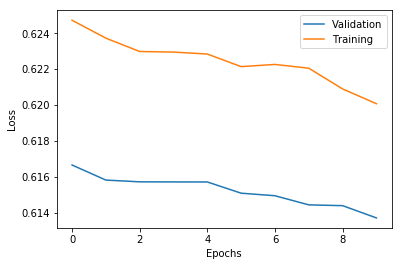

In [25]:
with open('./%s/hist_0.json' % path_info['model_info']['model_dir'], 'r') as f:
    history = json.load(f)
    
plt.plot(history['val_loss'], label='Validation')
plt.plot(history['loss'], label='Training')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## 6. Load the pre-trained network for testing

To test the trained model, we can use the `deepbiome_test` function. 

If you use the index file (`idx_path`), this function provides the evaluation using the test index (index set not included in the index file) for each fold. If not, this function provides the evaluation using the whole samples. 

If `number_of_fold` is set to `k`, the function will test the model only with first `k` folds.

We can use the testing metrics different with the training. In the example below, we additionally used `AUC` metric.

In [26]:
test_network_info = {
    'architecture_info': {
        'batch_normalization': 'False',
        'drop_out': '0',
        'weight_initial': 'glorot_uniform',
        'weight_l1_penalty':'0.',
        'weight_decay': 'phylogenetic_tree',
    },
    'model_info': {
        'lr': '0.01',
        'decay': '0.001',
        'loss': 'binary_crossentropy',
        'metrics': 'binary_accuracy, sensitivity, specificity, gmeasure, auc',
        'taxa_selection_metrics': 'sensitivity, specificity, gmeasure, accuracy',
        'network_class': 'DeepBiomeNetwork',
        'optimizer': 'adam',
        'reader_class': 'MicroBiomeClassificationReader',
        'normalizer': 'normalize_minmax',
    },
    'test_info': {
        'batch_size': 'None'
    }
}

In [27]:
test_path_info = {
    'data_info': {
        'data_path': resource_filename('deepbiome', 'tests/data'),
        'idx_path': resource_filename('deepbiome', 'tests/data/onefile_idx.csv'),
        'tree_info_path': resource_filename('deepbiome', 'tests/data/genus48_dic.csv'),
        'x_path': 'onefile_x.csv',
        'y_path': 'classification_y.csv'
    },
    'model_info': {
        'evaluation': 'eval.npy',
        'model_dir': './example_result/',
        'weight': 'weight.h5'
    }
}

In [28]:
evaluation = deepbiome.deepbiome_test(log, test_network_info, test_path_info, number_of_fold=None)

[root    |INFO|deepbiome.py:268] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:300] Test Evaluation : ['loss' 'binary_accuracy' 'sensitivity' 'specificity' 'gmeasure' 'auc']
[root    |INFO|deepbiome.py:302] -------1 fold test start!----------------------------------
[root    |INFO|readers.py:57] -----------------------------------------------------------------------
[root    |INFO|readers.py:58] Construct Dataset
[root    |INFO|readers.py:59] -----------------------------------------------------------------------
[root    |INFO|readers.py:60] Load data
[root    |INFO|deepbiome.py:312] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:313] Build network for 1 fold testing
[root    |INFO|build_network.py:506] ------------------------------------------------------------------------------------------
[root    |INFO|build_network.py:507] Read phylogenetic tree information from /DATA/home/muha/github_

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 48)                0         
_________________________________________________________________
l1_dense (Dense_with_tree)   (None, 40)                1960      
_________________________________________________________________
l1_activation (Activation)   (None, 40)                0         
_________________________________________________________________
l2_dense (Dense_with_tree)   (None, 23)                943       
_________________________________________________________________
l2_activation (Activation)   (None, 23)                0         
_________________________________________________________________
l3_dense (Dense_with_tree)   (None, 17)                408       
_________________________________________________________________
l3_activation (Activation)   (None, 17)                0   

[root    |INFO|build_network.py:57] Build Network
[root    |INFO|build_network.py:58] Optimizer = adam
[root    |INFO|build_network.py:59] Loss = binary_crossentropy
[root    |INFO|build_network.py:60] Metrics = binary_accuracy, sensitivity, specificity, gmeasure, auc
[root    |INFO|deepbiome.py:321] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:322] 1 fold computing start!----------------------------------
[root    |INFO|build_network.py:169] Evaluation start!


200/200 [==============================] - 0s 615us/step


[root    |INFO|build_network.py:174] Evaluation end with time 0.3142368793487549!
[root    |INFO|build_network.py:175] Evaluation: [0.6158955693244934, 0.6899999976158142, 1.0, 0.0, 0.0, 0.8218793869018555]
[root    |INFO|deepbiome.py:325] 
[root    |INFO|deepbiome.py:327] Compute time : 1.4775638580322266
[root    |INFO|deepbiome.py:328] 1 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:302] -------2 fold test start!----------------------------------
[root    |INFO|readers.py:57] -----------------------------------------------------------------------
[root    |INFO|readers.py:58] Construct Dataset
[root    |INFO|readers.py:59] -----------------------------------------------------------------------
[root    |INFO|readers.py:60] Load data
[root    |INFO|deepbiome.py:312] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:313] Build network for 2 fold testing
[root    |INFO|build_network.py:506] -----

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 48)                0         
_________________________________________________________________
l1_dense (Dense_with_tree)   (None, 40)                1960      
_________________________________________________________________
l1_activation (Activation)   (None, 40)                0         
_________________________________________________________________
l2_dense (Dense_with_tree)   (None, 23)                943       
_________________________________________________________________
l2_activation (Activation)   (None, 23)                0         
_________________________________________________________________
l3_dense (Dense_with_tree)   (None, 17)                408       
_________________________________________________________________
l3_activation (Activation)   (None, 17)                0   

[root    |INFO|build_network.py:57] Build Network
[root    |INFO|build_network.py:58] Optimizer = adam
[root    |INFO|build_network.py:59] Loss = binary_crossentropy
[root    |INFO|build_network.py:60] Metrics = binary_accuracy, sensitivity, specificity, gmeasure, auc
[root    |INFO|deepbiome.py:321] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:322] 2 fold computing start!----------------------------------
[root    |INFO|build_network.py:169] Evaluation start!


200/200 [==============================] - 0s 561us/step


[root    |INFO|build_network.py:174] Evaluation end with time 0.3044013977050781!
[root    |INFO|build_network.py:175] Evaluation: [0.5930360555648804, 0.7200000286102295, 1.0, 0.0, 0.0, 0.512090802192688]
[root    |INFO|deepbiome.py:325] 
[root    |INFO|deepbiome.py:327] Compute time : 1.4678938388824463
[root    |INFO|deepbiome.py:328] 2 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:302] -------3 fold test start!----------------------------------
[root    |INFO|readers.py:57] -----------------------------------------------------------------------
[root    |INFO|readers.py:58] Construct Dataset
[root    |INFO|readers.py:59] -----------------------------------------------------------------------
[root    |INFO|readers.py:60] Load data
[root    |INFO|deepbiome.py:312] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:313] Build network for 3 fold testing
[root    |INFO|build_network.py:506] ------

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 48)                0         
_________________________________________________________________
l1_dense (Dense_with_tree)   (None, 40)                1960      
_________________________________________________________________
l1_activation (Activation)   (None, 40)                0         
_________________________________________________________________
l2_dense (Dense_with_tree)   (None, 23)                943       
_________________________________________________________________
l2_activation (Activation)   (None, 23)                0         
_________________________________________________________________
l3_dense (Dense_with_tree)   (None, 17)                408       
_________________________________________________________________
l3_activation (Activation)   (None, 17)                0   

[root    |INFO|build_network.py:57] Build Network
[root    |INFO|build_network.py:58] Optimizer = adam
[root    |INFO|build_network.py:59] Loss = binary_crossentropy
[root    |INFO|build_network.py:60] Metrics = binary_accuracy, sensitivity, specificity, gmeasure, auc
[root    |INFO|deepbiome.py:321] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:322] 3 fold computing start!----------------------------------
[root    |INFO|build_network.py:169] Evaluation start!


200/200 [==============================] - 0s 528us/step


[root    |INFO|build_network.py:174] Evaluation end with time 0.3045778274536133!
[root    |INFO|build_network.py:175] Evaluation: [0.6487306952476501, 0.6549999713897705, 1.0, 0.0, 0.0, 0.5225135684013367]
[root    |INFO|deepbiome.py:325] 
[root    |INFO|deepbiome.py:327] Compute time : 1.6611065864562988
[root    |INFO|deepbiome.py:328] 3 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:302] -------4 fold test start!----------------------------------
[root    |INFO|readers.py:57] -----------------------------------------------------------------------
[root    |INFO|readers.py:58] Construct Dataset
[root    |INFO|readers.py:59] -----------------------------------------------------------------------
[root    |INFO|readers.py:60] Load data
[root    |INFO|deepbiome.py:312] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:313] Build network for 4 fold testing
[root    |INFO|build_network.py:506] -----

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 48)                0         
_________________________________________________________________
l1_dense (Dense_with_tree)   (None, 40)                1960      
_________________________________________________________________
l1_activation (Activation)   (None, 40)                0         
_________________________________________________________________
l2_dense (Dense_with_tree)   (None, 23)                943       
_________________________________________________________________
l2_activation (Activation)   (None, 23)                0         
_________________________________________________________________
l3_dense (Dense_with_tree)   (None, 17)                408       
_________________________________________________________________
l3_activation (Activation)   (None, 17)                0   

[root    |INFO|build_network.py:57] Build Network
[root    |INFO|build_network.py:58] Optimizer = adam
[root    |INFO|build_network.py:59] Loss = binary_crossentropy
[root    |INFO|build_network.py:60] Metrics = binary_accuracy, sensitivity, specificity, gmeasure, auc
[root    |INFO|deepbiome.py:321] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:322] 4 fold computing start!----------------------------------
[root    |INFO|build_network.py:169] Evaluation start!


200/200 [==============================] - 0s 550us/step


[root    |INFO|build_network.py:174] Evaluation end with time 0.29938602447509766!
[root    |INFO|build_network.py:175] Evaluation: [0.6190432906150818, 0.6899999976158142, 1.0, 0.0, 0.0, 0.6135460734367371]
[root    |INFO|deepbiome.py:325] 
[root    |INFO|deepbiome.py:327] Compute time : 1.5785729885101318
[root    |INFO|deepbiome.py:328] 4 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:302] -------5 fold test start!----------------------------------
[root    |INFO|readers.py:57] -----------------------------------------------------------------------
[root    |INFO|readers.py:58] Construct Dataset
[root    |INFO|readers.py:59] -----------------------------------------------------------------------
[root    |INFO|readers.py:60] Load data
[root    |INFO|deepbiome.py:312] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:313] Build network for 5 fold testing
[root    |INFO|build_network.py:506] ----

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 48)                0         
_________________________________________________________________
l1_dense (Dense_with_tree)   (None, 40)                1960      
_________________________________________________________________
l1_activation (Activation)   (None, 40)                0         
_________________________________________________________________
l2_dense (Dense_with_tree)   (None, 23)                943       
_________________________________________________________________
l2_activation (Activation)   (None, 23)                0         
_________________________________________________________________
l3_dense (Dense_with_tree)   (None, 17)                408       
_________________________________________________________________
l3_activation (Activation)   (None, 17)                0   

[root    |INFO|build_network.py:57] Build Network
[root    |INFO|build_network.py:58] Optimizer = adam
[root    |INFO|build_network.py:59] Loss = binary_crossentropy
[root    |INFO|build_network.py:60] Metrics = binary_accuracy, sensitivity, specificity, gmeasure, auc
[root    |INFO|deepbiome.py:321] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:322] 5 fold computing start!----------------------------------
[root    |INFO|build_network.py:169] Evaluation start!


200/200 [==============================] - 0s 569us/step


[root    |INFO|build_network.py:174] Evaluation end with time 0.3088035583496094!
[root    |INFO|build_network.py:175] Evaluation: [0.5993730425834656, 0.7049999833106995, 1.0, 0.0, 0.0, 0.9160956740379333]
[root    |INFO|deepbiome.py:325] 
[root    |INFO|deepbiome.py:327] Compute time : 1.5823745727539062
[root    |INFO|deepbiome.py:328] 5 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:331] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:333] Test Evaluation : ['loss' 'binary_accuracy' 'sensitivity' 'specificity' 'gmeasure' 'auc']
[root    |INFO|deepbiome.py:336]       mean : [0.61521573 0.692      1.         0.         0.         0.6772251 ]
[root    |INFO|deepbiome.py:337]        std : [0.01939739 0.02158705 0.         0.         0.         0.16324462]
[root    |INFO|deepbiome.py:338] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:341] Total Comp

This function provides the evaluation result as a numpy array with a shape of (number of folds, number of evaluation measures).

In [29]:
print('      %s' % ''.join(['%16s'%'loss']+ ['%16s'%s.strip() for s in test_network_info['model_info']['metrics'].split(',')]))
print('Mean: %s' % ''.join(['%16.4f'%v for v in np.mean(evaluation, axis=0)]))
print('Std : %s' % ''.join(['%16.4f'%v for v in np.std(evaluation, axis=0)]))

                  loss binary_accuracy     sensitivity     specificity        gmeasure             auc
Mean:           0.6152          0.6920          1.0000          0.0000          0.0000          0.6772
Std :           0.0194          0.0216          0.0000          0.0000          0.0000          0.1632


## 7. Load the pre-trained network for prediction

If you want to predict using the pre-trained model, you can use the `deepbiome_prediction` function. If `number_of_fold` is setted as `k`, the function will predict only with first `k` folds sample's outputs. 

If `change_weight_for_each_fold` is set as `False`, the function will predict the output of every folds by same weight from the given path. If `change_weight_for_each_fold` is set as `True`, the function will predict the output of by each fold weight.

If 'get_y=True', the function will provide a list of tuples (prediction, true output) as a output with the shape of `(n_samples, 2, n_classes)`. If 'get_y=False', the function will provide predictions only. The output will have the shape of `(n_samples, n_classes)`.

### 7.1 Prediction with fixed weight

If we want to predict new data from one pre-trained model, we can use the option below. We fixed the weight `weight_0.h5` for predicting the whole samples from `onefile_x.csv` (without using index file).

In [30]:
prediction_network_info = {
    'architecture_info': {
        'batch_normalization': 'False',
        'drop_out': '0',
        'weight_initial': 'glorot_uniform',
        'weight_l1_penalty':'0.',
        'weight_decay': 'phylogenetic_tree',
    },
    'model_info': {
        'decay': '0.001',
        'loss': 'binary_crossentropy',
        'lr': '0.01',
        'metrics': 'binary_accuracy, sensitivity, specificity, gmeasure, auc',
        'network_class': 'DeepBiomeNetwork',
        'normalizer': 'normalize_minmax',
        'optimizer': 'adam',
        'reader_class': 'MicroBiomeClassificationReader',
        'taxa_selection_metrics': 'sensitivity, specificity, gmeasure, accuracy',
    },
    'test_info': {
        'batch_size': 'None'
    }
}

In [31]:
prediction_path_info = {
    'data_info': {
        'data_path': resource_filename('deepbiome', 'tests/data'),
        'tree_info_path': resource_filename('deepbiome', 'tests/data/genus48_dic.csv'),
        'x_path': 'onefile_x.csv',
        'y_path': 'classification_y.csv'
    },
    'model_info': {
        'model_dir': './example_result/',
        'weight': 'weight_0.h5'
    }
}

In [32]:
prediction = deepbiome.deepbiome_prediction(log, prediction_network_info, prediction_path_info,
                                            num_classes = 1, number_of_fold=None)

[root    |INFO|deepbiome.py:411] -----------------------------------------------------------------
[root    |INFO|build_network.py:506] ------------------------------------------------------------------------------------------
[root    |INFO|build_network.py:507] Read phylogenetic tree information from /DATA/home/muha/github_repos/deepbiome/deepbiome/tests/data/genus48_dic.csv
[root    |INFO|build_network.py:512] Phylogenetic tree level list: ['Genus', 'Family', 'Order', 'Class', 'Phylum']
[root    |INFO|build_network.py:513] ------------------------------------------------------------------------------------------
[root    |INFO|build_network.py:520]      Genus: 48
[root    |INFO|build_network.py:520]     Family: 40
[root    |INFO|build_network.py:520]      Order: 23
[root    |INFO|build_network.py:520]      Class: 17
[root    |INFO|build_network.py:520]     Phylum: 9
[root    |INFO|build_network.py:524] ---------------------------------------------------------------------------------

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 48)                0         
_________________________________________________________________
l1_dense (Dense_with_tree)   (None, 40)                1960      
_________________________________________________________________
l1_activation (Activation)   (None, 40)                0         
_________________________________________________________________
l2_dense (Dense_with_tree)   (None, 23)                943       
_________________________________________________________________
l2_activation (Activation)   (None, 23)                0         
_________________________________________________________________
l3_dense (Dense_with_tree)   (None, 17)                408       
_________________________________________________________________
l3_activation (Activation)   (None, 17)                0   

[root    |INFO|build_network.py:57] Build Network
[root    |INFO|build_network.py:58] Optimizer = adam
[root    |INFO|build_network.py:59] Loss = binary_crossentropy
[root    |INFO|build_network.py:60] Metrics = binary_accuracy, sensitivity, specificity, gmeasure, auc
[root    |INFO|deepbiome.py:444] -------1 th repeatition prediction start!----------------------------------
[root    |INFO|readers.py:57] -----------------------------------------------------------------------
[root    |INFO|readers.py:58] Construct Dataset
[root    |INFO|readers.py:59] -----------------------------------------------------------------------
[root    |INFO|readers.py:60] Load data
[root    |INFO|deepbiome.py:462] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:468] -----------------------------------------------------------------
[root    |INFO|build_network.py:189] Prediction start!


1000/1000 [==============================] - 0s 48us/step


[root    |INFO|build_network.py:194] Prediction end with time 0.051407814025878906!
[root    |INFO|deepbiome.py:472] Compute time : 0.27307629585266113
[root    |INFO|deepbiome.py:473] 1 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:478] Total Computing Ended
[root    |INFO|deepbiome.py:479] -----------------------------------------------------------------


In [33]:
prediction.shape

(1, 1000, 1)

In [34]:
prediction[0,:10]

array([[0.685398  ],
       [0.6857323 ],
       [0.68103904],
       [0.6754241 ],
       [0.68580693],
       [0.6838119 ],
       [0.68383193],
       [0.6794928 ],
       [0.6842766 ],
       [0.68606365]], dtype=float32)

### 7.2 Prediction with each fold weight

If we want to predict the cross-validation outputs, we can use the option belows.

The example below shows how to predict the 5-fold cross-validation outputs. (If we use the leave-one-out-cross-validation (LOOCV) for training, we can predict the LOOCV outputs by same way.)
We set `idx_path` for using the index file `onefile_idx.csv` to predict only the test set for each fold.

In [35]:
prediction_network_info = {
    'architecture_info': {
        'batch_normalization': 'False',
        'drop_out': '0',
        'weight_initial': 'glorot_uniform',
        'weight_l1_penalty':'0.',
        'weight_decay': 'phylogenetic_tree',
    },
    'model_info': {
        'decay': '0.001',
        'loss': 'binary_crossentropy',
        'lr': '0.01',
        'metrics': 'binary_accuracy, sensitivity, specificity, gmeasure, auc',
        'network_class': 'DeepBiomeNetwork',
        'normalizer': 'normalize_minmax',
        'optimizer': 'adam',
        'reader_class': 'MicroBiomeClassificationReader',
        'taxa_selection_metrics': 'sensitivity, specificity, gmeasure, accuracy',
    },
    'test_info': {
        'batch_size': 'None'
    }
}

In [36]:
prediction_path_info = {
    'data_info': {
        'data_path': resource_filename('deepbiome', 'tests/data'),
        'idx_path': resource_filename('deepbiome', 'tests/data/onefile_idx.csv'),
        'tree_info_path': resource_filename('deepbiome', 'tests/data/genus48_dic.csv'),
        'x_path': 'onefile_x.csv',
        'y_path': 'classification_y.csv'
    },
    'model_info': {
        'model_dir': './example_result/',
        'weight': 'weight.h5'
    }
}

To predict the CV outputs from each fold, we set `change_weight_for_each_fold = True`. Also, we set `get_y=True` to get the paired output of each prediction too.

In [37]:
prediction = deepbiome.deepbiome_prediction(log, prediction_network_info, prediction_path_info,
                                            num_classes = 1, number_of_fold=None, 
                                            change_weight_for_each_fold = True, 
                                            get_y=True)

[root    |INFO|deepbiome.py:411] -----------------------------------------------------------------
[root    |INFO|build_network.py:506] ------------------------------------------------------------------------------------------
[root    |INFO|build_network.py:507] Read phylogenetic tree information from /DATA/home/muha/github_repos/deepbiome/deepbiome/tests/data/genus48_dic.csv
[root    |INFO|build_network.py:512] Phylogenetic tree level list: ['Genus', 'Family', 'Order', 'Class', 'Phylum']
[root    |INFO|build_network.py:513] ------------------------------------------------------------------------------------------
[root    |INFO|build_network.py:520]      Genus: 48
[root    |INFO|build_network.py:520]     Family: 40
[root    |INFO|build_network.py:520]      Order: 23
[root    |INFO|build_network.py:520]      Class: 17
[root    |INFO|build_network.py:520]     Phylum: 9
[root    |INFO|build_network.py:524] ---------------------------------------------------------------------------------

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 48)                0         
_________________________________________________________________
l1_dense (Dense_with_tree)   (None, 40)                1960      
_________________________________________________________________
l1_activation (Activation)   (None, 40)                0         
_________________________________________________________________
l2_dense (Dense_with_tree)   (None, 23)                943       
_________________________________________________________________
l2_activation (Activation)   (None, 23)                0         
_________________________________________________________________
l3_dense (Dense_with_tree)   (None, 17)                408       
_________________________________________________________________
l3_activation (Activation)   (None, 17)                0   

[root    |INFO|build_network.py:57] Build Network
[root    |INFO|build_network.py:58] Optimizer = adam
[root    |INFO|build_network.py:59] Loss = binary_crossentropy
[root    |INFO|build_network.py:60] Metrics = binary_accuracy, sensitivity, specificity, gmeasure, auc
[root    |INFO|deepbiome.py:444] -------1 th repeatition prediction start!----------------------------------
[root    |INFO|readers.py:57] -----------------------------------------------------------------------
[root    |INFO|readers.py:58] Construct Dataset
[root    |INFO|readers.py:59] -----------------------------------------------------------------------
[root    |INFO|readers.py:60] Load data
[root    |INFO|deepbiome.py:462] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:468] -----------------------------------------------------------------
[root    |INFO|build_network.py:189] Prediction start!


200/200 [==============================] - 0s 244us/step


[root    |INFO|build_network.py:194] Prediction end with time 0.05227160453796387!
[root    |INFO|deepbiome.py:472] Compute time : 0.27782773971557617
[root    |INFO|deepbiome.py:473] 1 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:444] -------2 th repeatition prediction start!----------------------------------
[root    |INFO|readers.py:57] -----------------------------------------------------------------------
[root    |INFO|readers.py:58] Construct Dataset
[root    |INFO|readers.py:59] -----------------------------------------------------------------------
[root    |INFO|readers.py:60] Load data
[root    |INFO|deepbiome.py:462] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:468] -----------------------------------------------------------------
[root    |INFO|build_network.py:189] Prediction start!


200/200 [==============================] - 0s 5us/step


[root    |INFO|build_network.py:194] Prediction end with time 0.0028352737426757812!
[root    |INFO|deepbiome.py:472] Compute time : 0.05332684516906738
[root    |INFO|deepbiome.py:473] 2 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:444] -------3 th repeatition prediction start!----------------------------------
[root    |INFO|readers.py:57] -----------------------------------------------------------------------
[root    |INFO|readers.py:58] Construct Dataset
[root    |INFO|readers.py:59] -----------------------------------------------------------------------
[root    |INFO|readers.py:60] Load data
[root    |INFO|deepbiome.py:462] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:468] -----------------------------------------------------------------
[root    |INFO|build_network.py:189] Prediction start!


200/200 [==============================] - 0s 5us/step


[root    |INFO|build_network.py:194] Prediction end with time 0.002824068069458008!
[root    |INFO|deepbiome.py:472] Compute time : 0.050748586654663086
[root    |INFO|deepbiome.py:473] 3 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:444] -------4 th repeatition prediction start!----------------------------------
[root    |INFO|readers.py:57] -----------------------------------------------------------------------
[root    |INFO|readers.py:58] Construct Dataset
[root    |INFO|readers.py:59] -----------------------------------------------------------------------
[root    |INFO|readers.py:60] Load data
[root    |INFO|deepbiome.py:462] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:468] -----------------------------------------------------------------
[root    |INFO|build_network.py:189] Prediction start!


200/200 [==============================] - 0s 5us/step


[root    |INFO|build_network.py:194] Prediction end with time 0.002480030059814453!
[root    |INFO|deepbiome.py:472] Compute time : 0.05277109146118164
[root    |INFO|deepbiome.py:473] 4 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:444] -------5 th repeatition prediction start!----------------------------------
[root    |INFO|readers.py:57] -----------------------------------------------------------------------
[root    |INFO|readers.py:58] Construct Dataset
[root    |INFO|readers.py:59] -----------------------------------------------------------------------
[root    |INFO|readers.py:60] Load data
[root    |INFO|deepbiome.py:462] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:468] -----------------------------------------------------------------
[root    |INFO|build_network.py:189] Prediction start!


200/200 [==============================] - 0s 5us/step


[root    |INFO|build_network.py:194] Prediction end with time 0.002643585205078125!
[root    |INFO|deepbiome.py:472] Compute time : 0.045223236083984375
[root    |INFO|deepbiome.py:473] 5 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:478] Total Computing Ended
[root    |INFO|deepbiome.py:479] -----------------------------------------------------------------


We gathered the outputs from each fold. 

In [38]:
prediction = np.vstack(prediction)

Since we set the option `get_y=True`, the output has the shape of `(n_samples, 2, n_classes)`. With this options, we can get the CV predictions and the true output of each predictions.

Now, we can calculate the CV performance by the CV predictions.

In [39]:
predict_output = prediction[:,0]
true_output = prediction[:,1]

log.info('Shape of the predict function ourput: %s' % str(prediction.shape))
log.info('Shape of the prediction: %s' % str(predict_output.shape))
log.info('Shape of the true_output for each prediction: %s' % str(true_output.shape))

[root    |INFO|<ipython-input-39-dc5b95be41ff>:4] Shape of the predict function ourput: (1000, 2, 1)
[root    |INFO|<ipython-input-39-dc5b95be41ff>:5] Shape of the prediction: (1000, 1)
[root    |INFO|<ipython-input-39-dc5b95be41ff>:6] Shape of the true_output for each prediction: (1000, 1)


In [40]:
log.info('CV accuracy: %6.3f' % np.mean((predict_output >= 0.5) ==  true_output))

[root    |INFO|<ipython-input-40-ecaee2413087>:1] CV accuracy:  0.692


## 8. Load trained weight matrix

The `deepbiome_get_trained_weight` function convert the trained weight `*.h5` saved from the `deepbiome_train` to a list of numpy arrays.
In this exampe, the list has numpy array of weights from 6 layers. (`[genus to family, family to order, order to Class, class to phylum, phylum to output]`)

In [41]:
weight_path = '%s/%s' % (prediction_path_info['model_info']['model_dir'], 'weight_0.h5')
trained_weight_list = deepbiome.deepbiome_get_trained_weight(log, network_info, path_info, num_classes=1, weight_path=weight_path)
log.info(len(trained_weight_list))

[root    |INFO|<ipython-input-41-d6c43d8a172c>:3] 5


First weight between the `genus` and `family` layers has the shape of `(number of genus = 48, number of family = 40)`

In [42]:
log.info(trained_weight_list[0].shape)

[root    |INFO|<ipython-input-42-c71fa46ab178>:1] (48, 40)


## 9. Taxa selection performance

If we know the true disease path, we can calculate the taxa selection performance by `deepbiome_taxa_selection_performance` funciton. First, we prepared the true weight list based on the true disease path. For each fold, we prepared 4 weights from the 5 layers (`[genus to family, family to order, order to Class, class to phylum]`). An example of the list of the true weights from each fold is as follow:

In [43]:
true_tree_weight_list = np.load(resource_filename('deepbiome', 'tests/data/true_weight_list.npy'), allow_pickle=True)
log.info(true_tree_weight_list.shape)

[root    |INFO|<ipython-input-43-7f16305fbcb7>:2] (5, 4)


The first weight between the genus and family layers for first epoch has the shape below:

In [44]:
log.info(true_tree_weight_list[0][0].shape)

[root    |INFO|<ipython-input-44-7f1406e7d9a7>:1] (48, 40)


We will calculate the taxa selection performance of the trained weight below:

In [45]:
trained_weight_path_list = ['%s/weight_%d.h5' % (prediction_path_info['model_info']['model_dir'], i) for i in range(5)]
trained_weight_path_list

['./example_result//weight_0.h5',
 './example_result//weight_1.h5',
 './example_result//weight_2.h5',
 './example_result//weight_3.h5',
 './example_result//weight_4.h5']

This is the summary of the taxa selection accuracy of trained weights from each fold.

In [46]:
summary = deepbiome.deepbiome_taxa_selection_performance(log, network_info, path_info, num_classes=1, 
                                                         true_tree_weight_list=true_tree_weight_list, 
                                                         trained_weight_path_list = trained_weight_path_list)

In [47]:
summary

,Model,PhyloTree,No. true taxa,No. total taxa,Sensitivity_mean,Sensitivity_std,Specificity_mean,Specificity_std,Gmeasure_mean,Gmeasure_std,Accuracy_mean,Accuracy_std
0,./example_result/,Genus,31,48,0.961290,0.012903,0.983166,0.010974,0.972144,0.010089,0.982812,0.010885
1,,Family,23,40,0.982609,0.021300,0.971683,0.011577,0.977069,0.013102,0.971957,0.011408
2,,Order,9,23,0.977778,0.044444,0.954974,0.010392,0.965986,0.020884,0.955499,0.009786
3,,Class,7,17,1.000000,0.000000,0.931507,0.000000,0.965146,0.000000,0.934641,0.000000


## 10. Draw phylogenetic tree

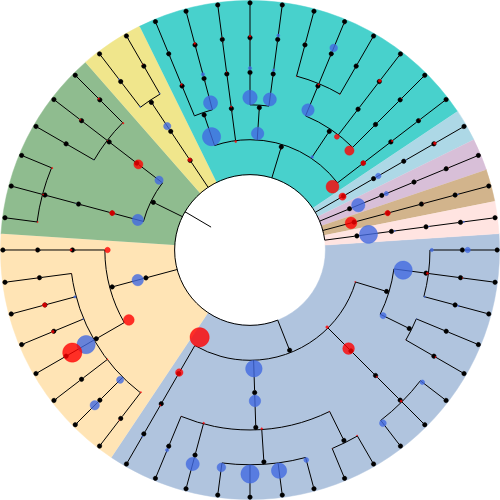

In [48]:
phylumn_color = ['lightsteelblue', 
                 'moccasin',
                 'darkseagreen',
                 'khaki',
                 'mediumturquoise',
                 'lightblue',
                 'thistle',
                 'tan',
                 'mistyrose',
                ]

deepbiome.deepbiome_draw_phylogenetic_tree(log, network_info, path_info, num_classes=1,
                                 file_name='%%inline', img_w=500, branch_vertical_margin=20, arc_start=0, arc_span=360, 
                                 node_name_on=False, name_fsize=50, 
                                 tree_weight_on=True, tree_weight=trained_weight_list[:4],
                                 weight_opacity=0.8, weight_max_radios=20, 
                                 background_color_on=True, phylumn_color=phylumn_color)

### With name

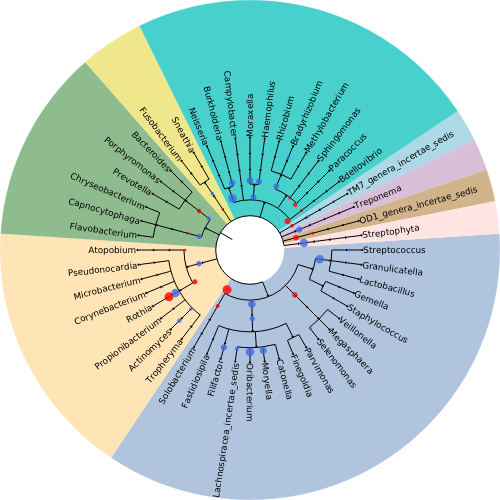

In [49]:
deepbiome.deepbiome_draw_phylogenetic_tree(log, network_info, path_info, num_classes=1,
                                 file_name='%%inline', img_w=500, branch_vertical_margin=20, arc_start=0, arc_span=360, 
                                 node_name_on=True, name_fsize=30, 
                                 tree_weight_on=True, tree_weight=trained_weight_list[:4],
                                 weight_opacity=0.8, weight_max_radios=20, 
                                 background_color_on=True, phylumn_color=phylumn_color)